<a href="https://colab.research.google.com/github/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/notebooks/Predicci%C3%B3n_precios_casas_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-dotenv

In [ ]:
# Data Wrangling
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
)

# Modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Visualization
# import cufflinks as cf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Configuración del notebook
# cf.go_offline()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

# Librerías adicionales
import os
import random
import re
import shutil
import time
import math

# Librerías de terceros
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Librerías de imágenes
from PIL import Image, ImageOps, ImageFilter, ImageEnhance

# Librerías de TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    BatchNormalization,
)
from keras.metrics import (
    RootMeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)

import time
import requests
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import time
from IPython.display import clear_output
import tensorflow as tf

from dotenv import load_dotenv

# Cargar variables de entorno desde el archivo .env
load_dotenv()


class TelegramNotifier:
    def __init__(self, chat_id):
        self.bot_token = os.getenv("TELEGRAM_BOT_TOKEN")  # Leer bot_token del .env
        self.chat_id = chat_id

    def send_telegram_message(self, message):
        if not self.bot_token:
            raise ValueError("El token del bot no se ha configurado correctamente.")

        url = f"https://api.telegram.org/bot{self.bot_token}/sendMessage"
        payload = {
            "chat_id": self.chat_id,
            "text": message,
            "parse_mode": "Markdown"
        }
        response = requests.post(url, data=payload)
        if response.status_code != 200:
            print(
                f"Error al enviar mensaje a Telegram: {response.status_code} - {response.text}"
            )


class CustomLogger(tf.keras.callbacks.Callback, TelegramNotifier):
    def __init__(self, metric="val_accuracy", total_epochs=100, chat_id="chat_id"):
        # Inicialización de la clase base TelegramNotifier
        TelegramNotifier.__init__(self, chat_id)

        # Inicialización del Callback de Keras
        super(CustomLogger, self).__init__()

        self.epoch_logs = []
        self.best_score = (
            float("inf") if metric in ["val_rms", "val_mae"] else 0
        )  # Inicializa según la métrica
        self.best_epoch_log = {}
        self.best_epoch_index = 0
        self.metric = metric  # Guarda la métrica a utilizar
        self.start_time = time.time()  # Guarda el tiempo de inicio
        self.total_epochs = total_epochs  # Total de épocas para el entrenamiento
        self.epoch_times = []  # Lista para almacenar los tiempos de cada época

    def on_train_begin(self, logs=None):
        # Enviar mensaje al iniciar el entrenamiento
        message = "Comenzando el entrenamiento 💡📚🧠..."
        self.send_telegram_message(message)

    def on_epoch_end(self, epoch, logs=None):
        # Guardar los logs de la época actual
        self.epoch_logs.append(logs)

        # Obtener el valor actual de la métrica
        current_score = logs.get(self.metric)
        current_loss = logs.get("loss")
        current_lr = logs.get("lr")

        # Calcular el tiempo transcurrido
        elapsed_time = (time.time() - self.start_time) / 60
        self.epoch_times.append(elapsed_time)  # Agregar tiempo de la época actual

        avg_epoch_time = self.calculate_avg_time(epoch)

        # Calcular el número de épocas restantes
        remaining_epochs = self.total_epochs - (epoch + 1)

        # Calcular el tiempo estimado restante
        estimated_time_remaining = remaining_epochs * avg_epoch_time

        # Actualizar el mejor score y el log correspondiente
        if (
            self.metric in ["val_rms", "val_mae"] and current_score < self.best_score
        ) or (self.metric == "val_accuracy" and current_score > self.best_score):
            self.best_score = current_score
            self.best_epoch_log = logs.copy()  # Almacenar el log del mejor epoch
            self.best_epoch_index = epoch

            # Enviar un mensaje a Telegram con los detalles
            message = (
                f"*Mejor Epoch* {self.best_epoch_index} \n"
                f"*Learning rate: * {current_lr}\n"
                f"{self.metric.replace('_', ' ')} = *{round(self.best_score, 4):.4f}* (loss {current_loss:.4})\n"
                f"Tiempo estimado restante: {estimated_time_remaining:.2f} minutos"
            )
            self.send_telegram_message(message)

        # Mantener solo las últimas 10 épocas
        if len(self.epoch_logs) > 10:
            self.epoch_logs.pop(0)

        # Limpiar la salida anterior
        clear_output(wait=True)

        # Mostrar las últimas 10 épocas
        print("\nÚltimas 10 épocas:")
        for i, log in enumerate(self.epoch_logs):
            epoch_num = epoch - len(self.epoch_logs) + i + 1
            rounded_log = {
                k: round(v, 4) for k, v in log.items()
            }  # Redondear los valores de logs
            print(f"Epoch {epoch_num}: {rounded_log}")

        # Mostrar el log de la mejor época
        rounded_best_log = {
            k: round(v, 4) if k != 'lr' else round(v, 8) for k, v in self.best_epoch_log.items()
        }
        print("\n🏆 Mejor Epoch:")
        print(
            f"Epoch {self.best_epoch_index} ({self.metric}={round(self.best_score, 4):.4f}): {rounded_best_log}"
        )

        # Mostrar el tiempo transcurrido
        print(f"\nTiempo transcurrido: {elapsed_time:.2f} minutos")
        print(f"Tiempo promedio por época: {avg_epoch_time:.2f} minutos")
        print(f"Tiempo estimado restante: {estimated_time_remaining:.2f} minutos")

    def on_train_end(self, logs=None):
        # Enviar mensaje al finalizar el entrenamiento
        message = "🚀 Modelo entrenado exitosamente."
        self.send_telegram_message(message)

    def calculate_avg_time(self, epoch):
        # Si hay más de un tiempo de época registrado, calcular el tiempo promedio por época
        if len(self.epoch_times) > 1:
            # Tiempo promedio de la última época
            avg_epoch_time = self.epoch_times[-1] - self.epoch_times[-2]
        else:
            # Si solo hay una época registrada, usar el tiempo de esa única época
            avg_epoch_time = self.epoch_times[-1]

        return avg_epoch_time


def process_image(image, size=(200, 200)):
    """Carga una imagen desde una ruta y la redimensiona, normalizándola entre [0, 1]."""
    resized_image = image.resize(size, Image.BICUBIC)
    # highlighted_edges = detect_edges(resized_image)

    return np.array(resized_image) / 255.0


def load_images_for_house(house_id, images_dir, size, how="concatenate"):
    """Carga y procesa todas las imágenes asociadas a una casa en un orden específico."""
    house_images = [
        img for img in os.listdir(images_dir) if img.split("_")[0] == str(house_id)
    ]

    # Verificar la cantidad de imágenes
    if len(house_images) != 4:
        print(
            f"Advertencia: Se esperaban 4 imágenes para la casa {house_id}, pero se encontraron {len(house_images)}."
        )
        return None

    # Definir el orden deseado
    desired_order = {"frontal": 0, "bathroom": 1, "bedroom": 2, "kitchen": 3}

    # Ordenar las imágenes según el orden deseado
    sorted_images = sorted(
        house_images,
        key=lambda img: desired_order.get(img.split("_")[1].replace(".jpg", ""), 4),
    )

    processed_images = []
    for img_name in sorted_images:
        img_path = os.path.join(images_dir, img_name)
        try:
            image = Image.open(img_path)
        except Exception as e:
            print(f"Error al cargar la imagen {img_path}: {e}")
            return None

        processed_image = process_image(image, size)

        if processed_image is not None:
            processed_images.append(processed_image)

    # Si se encuentran imágenes, devolver la concatenación
    if processed_images and how == "concatenate":
        # return np.concatenate(processed_images, axis=0)  # Concatenar imágenes
        top_row = np.hstack(
            (processed_images[0], processed_images[1])
        )  # Combina la fila superior
        bottom_row = np.hstack(
            (processed_images[2], processed_images[3])
        )  # Combina la fila inferior
        combined_img = np.vstack((top_row, bottom_row))
        return combined_img
    elif processed_images and how == "mean":
        return np.mean(processed_images, axis=0)  # Promediar imágenes
    else:
        print(f"No se encontraron imágenes procesadas para la casa {house_id}")
        return None


def load_all_houses_images_and_prices(
    metadata, images_dir, size=(200, 200), how="concatenate"
):
    """Carga todas las imágenes y precios asociados a las casas del metadata."""
    house_images = []
    house_prices = []

    for index, row in metadata.iterrows():
        house_id = row["img"]
        price = row["price"]

        concatenated_images = load_images_for_house(house_id, images_dir, size, how=how)

        if concatenated_images is not None:
            house_images.append(concatenated_images)
            house_prices.append(price)

    # Convertir listas a arrays numpy
    return np.array(house_images), np.array(house_prices)


def show_images(images, num_images=4, prices=None):
    """
    Visualiza múltiples imágenes en una cuadrícula con la opción de agregar precios sobre las imágenes.
    Selecciona aleatoriamente un subconjunto de imágenes si es necesario.

    Parámetros:
    images (np.ndarray): Array de tamaño (N, H, W, 3) que contiene imágenes.
    num_images (int): Número de imágenes a mostrar.
    prices (list): Lista opcional de precios para cada imagen.
    """
    # Asegura que num_images no exceda el número de imágenes disponibles
    num_images = min(num_images, images.shape[0])

    # Selecciona aleatoriamente las imágenes y sus precios (si se proporcionan)
    indices = np.random.choice(images.shape[0], num_images, replace=False)
    selected_images = images[indices]

    if prices is not None:
        selected_prices = [prices[i] for i in indices]
    else:
        selected_prices = None

    # Crea una cuadrícula de 1 fila y "num_images" columnas
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Ajusta el espaciado entre las imágenes
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    # Itera sobre las imágenes seleccionadas y los ejes de la cuadrícula
    for i in range(num_images):
        axes[i].imshow(selected_images[i])
        axes[i].axis("off")  # Oculta los ejes

        # Si se proporciona la lista de precios, muestra el precio sobre la imagen
        if selected_prices is not None and i < len(selected_prices):
            axes[i].text(
                10,
                20,
                f"${selected_prices[i]:,.2f}",
                color="white",
                fontsize=12,
                bbox=dict(facecolor="black", alpha=0.5),
            )

    plt.show()


def predict_from_folder(
    model, folder_path, target_size=(200, 200), how="median", scaler=None
):
    """
    Genera predicciones para imágenes en una carpeta usando el modelo entrenado.

    Args:
        model: El modelo entrenado para hacer predicciones.
        folder_path: Ruta a la carpeta que contiene las imágenes.
        target_size: Tamaño objetivo para redimensionar las imágenes.

    Returns:
        Un DataFrame con los resultados de las predicciones.
    """
    results = []

    unique_indices = get_unique_image_indices(folder_path)

    for idx in unique_indices:
        images = load_images_for_house(idx, folder_path, target_size, how)

        if images is not None:
            images = np.expand_dims(
                images, axis=0
            )  # Agrega una dimensión para el batch

            prediction = model.predict(images)

            if scaler:
                prediction = scaler.inverse_transform(prediction)

            results.append(
                {"img": idx, "predicted_price": prediction[0][0]}  # Obtén la predicción
            )

    df_results = pd.DataFrame(results)

    return df_results


def get_unique_image_indices(image_folder):
    """
    Obtiene los índices únicos de los nombres de archivo de imágenes.

    Args:
      image_folder: Ruta a la carpeta que contiene las imágenes.

    Returns:
      Una lista de índices únicos (parte numérica de los nombres de archivo).
    """
    image_filenames = os.listdir(image_folder)
    indices = []
    for filename in image_filenames:
        match = re.match(r"(\d+)_", filename)
        if match:
            indices.append(int(match.group(1)))

    unique_indices = sorted(list(set(indices)))

    return unique_indices


def get_image_sizes(path):
    # Crear listas para almacenar los datos
    filenames = []
    widths = []
    heights = []

    # Recorrer todos los archivos en el directorio
    for filename in os.listdir(path):
        if filename.endswith(".jpg") or filename.endswith(
            ".jpeg"
        ):  # Verificar si es un archivo JPG
            # Abrir la imagen y obtener sus dimensiones
            with Image.open(os.path.join(path, filename)) as img:
                width, height = img.size
                # Almacenar los datos
                filenames.append(filename)
                widths.append(width)
                heights.append(height)

    # Crear un DataFrame con los resultados
    df = pd.DataFrame({"filename": filenames, "width": widths, "height": heights})

    return df


def detect_edges(
    image,
    method="sobel",
    contrast_factor=1.5,
    blur_radius=2,
    canny_threshold1=50,
    canny_threshold2=150,
):
    # Convertir a escala de grises
    gray = image.convert("L")

    # Ajustar el contraste de la imagen
    enhancer = ImageEnhance.Contrast(gray)
    gray = enhancer.enhance(contrast_factor)

    # Aplicar suavizado (desenfoque) para reducir el ruido
    blurred = gray.filter(ImageFilter.GaussianBlur(blur_radius))

    # Convertir la imagen suavizada a un array numpy para usar OpenCV
    np_image = np.array(blurred)

    # Detectar bordes usando Sobel o Canny
    if method == "sobel":
        sobelx = cv2.Sobel(np_image, cv2.CV_64F, 1, 0, ksize=5)  # Derivada en x
        sobely = cv2.Sobel(np_image, cv2.CV_64F, 0, 1, ksize=5)  # Derivada en y
        edges = np.hypot(sobelx, sobely)  # Magnitud del gradiente
        edges = np.uint8(edges / edges.max() * 255)  # Normalizar a rango [0, 255]
    elif method == "canny":
        edges = cv2.Canny(np_image, canny_threshold1, canny_threshold2)
    else:
        raise ValueError("Método no reconocido: elige entre 'sobel' o 'canny'")

    # Convertir el array numpy de bordes a una imagen PIL
    edges_pil = Image.fromarray(edges)

    # Convertir los bordes a una máscara y colorizar
    mask = ImageOps.colorize(edges_pil, black="black", white="white")

    # Resaltar los bordes en la imagen original
    highlighted_edges = Image.blend(image, mask.convert("RGB"), alpha=0.5)

    return highlighted_edges


def plot_price_distribution(data, bins=15):
    """
    Muestra la distribución de precios usando un histograma con KDE y una línea de media.

    Parameters:
    - data: Serie de precios (pandas Series).
    - bins: Número de bins para el histograma.
    """
    # Calcular la media
    median_price = data.median()

    # Crear el histograma con KDE
    sns.histplot(data, bins=bins, kde=True)

    # Configurar el formato del eje x
    plt.gca().xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{int(x):,}")
    )

    # Rotar las etiquetas del eje x
    plt.xticks(rotation=45)

    # Añadir la línea de la media
    plt.axvline(median_price, color="red", linestyle="--", label="Mediana")

    # Añadir texto para la media
    plt.text(
        median_price,
        plt.ylim()[1] * 0.9,
        f"Mediana: {median_price:.2f}",
        color="red",
        fontsize=10,
        horizontalalignment="right",
    )

    # Añadir títulos y etiquetas
    plt.title("Distribución de Precios")
    plt.xlabel("Precio")
    plt.ylabel("Frecuencia")
    # plt.legend()  # Añadir leyenda

    # Mostrar el gráfico
    plt.show()


def plot_price_boxplot(data):
    """"""
    # Crear el boxplot
    sns.boxplot(x=data)

    # Configurar el formato del eje x
    plt.gca().xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{int(x):,}")
    )

    # Rotar las etiquetas del eje x
    plt.xticks(rotation=45)

    # Añadir títulos y etiquetas
    plt.title("Distribución de Precios")
    plt.xlabel("Precio")

    # Mostrar el gráfico
    plt.show()


def augment_image(image):
    """Aplica una serie de transformaciones aleatorias a la imagen"""
    if random.random() > 0.5:
        image = image.rotate(random.uniform(-45, 45))
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(random.uniform(0.7, 1.3))
    if random.random() > 0.5:
        enhancer = ImageEnhance.Color(image)
        image = enhancer.enhance(random.uniform(0.7, 1.3))
    if random.random() > 0.5:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(random.uniform(0.7, 1.3))
    if random.random() > 0.5:
        scale = random.uniform(0.8, 1.2)
        new_size = (int(image.width * scale), int(image.height * scale))
        image = image.resize(new_size)

    return image


def generate_augmented_images(df_intervals, df_images, input_dir, output_dir):
    """
    Genera imágenes aumentadas en función del intervalo de precios definido en df_intervals.
    El número de imágenes aumentadas por propiedad se basa en el multiplicador de df_intervals.

    Parameters:
    - df_intervals: DataFrame que contiene los intervalos de precios y el multiplicador.
    - df_images: DataFrame con las propiedades, incluyendo la columna de precio.
    - input_dir: Directorio donde se encuentran las imágenes originales.
    - output_dir: Directorio donde se guardarán las imágenes aumentadas.

    Retorna un DataFrame actualizado con los nuevos IDs de imágenes.
    """
    image_types = [
        "frontal",
        "kitchen",
        "bathroom",
        "bedroom",
    ]  # Los diferentes tipos de imagen
    new_rows = []  # Lista para almacenar las nuevas filas del DataFrame

    # Iterar sobre cada fila del DataFrame de imágenes
    for idx_img, row_img in df_images.iterrows():
        img_id = row_img["img"]
        price = row_img["price"]

        # Buscar en qué intervalo de precio cae la imagen
        for idx_interval, row_interval in df_intervals.iterrows():
            interval_str = row_interval["Interval"]
            multiplier = row_interval["multiplier"]

            # Convertir el intervalo de string a un rango numérico
            interval_min, interval_max = map(
                lambda x: float(x.replace(",", "").strip()),
                interval_str[1:-1].split("-"),
            )

            # Si el precio cae dentro del intervalo
            if interval_min < price <= interval_max and multiplier > 0:
                num_augmented = multiplier  # Usar el multiplicador como número de imágenes aumentadas

                # Generar imágenes aumentadas para cada tipo de imagen (frontal, cocina, baño, dormitorio)
                for img_type in image_types:
                    img_name = f"{img_id}_{img_type}.jpg"
                    img_path = os.path.join(input_dir, img_name)

                    if not os.path.exists(img_path):
                        print(f"Imagen {img_name} no encontrada. Saltando...")
                        continue

                    # Abrir la imagen original
                    image = Image.open(img_path)

                    # Generar las imágenes aumentadas y guardar en el disco
                    for i in range(1, num_augmented + 1):
                        augmented_image = augment_image(image)
                        new_img_id = f"{img_id}{i}"  # ID con sufijo
                        new_image_name = (
                            f"{new_img_id}_{img_type}.jpg"  # Nombre con sufijo
                        )
                        new_image_path = os.path.join(output_dir, new_image_name)
                        augmented_image.save(new_image_path)
                        print(f"Imagen {new_image_name} guardada en {output_dir}.")
                        clear_output(wait=True)

                        # Para solo guardar un registro por new_img_id en el tipo 'frontal'
                        if img_type == "frontal":
                            new_rows.append(
                                {
                                    "img": new_img_id,
                                    "n_rooms": row_img["n_rooms"],
                                    "n_bathrooms": row_img["n_bathrooms"],
                                    "area": row_img["area"],
                                    "zipcode": row_img["zipcode"],
                                    "price": price,
                                }
                            )

    # Convertir la lista de nuevas filas a un DataFrame
    new_df = pd.DataFrame(new_rows)

    # Concatenar el DataFrame original de imágenes con las nuevas filas
    updated_df = pd.concat([df_images, new_df], ignore_index=True)

    return updated_df


def evaluate_model(model, test_images, test_labels, scaler=None):
    """
    Evalúa un modelo de TensorFlow en un conjunto de imágenes de prueba y crea un DataFrame
    con los precios reales, precios predichos y la diferencia.
    Aplica un escalador si se proporciona.

    Parameters:
    - model: Modelo de TensorFlow entrenado.
    - test_images (np.ndarray): Conjunto de imágenes de prueba.
    - test_labels (np.ndarray): Etiquetas reales correspondientes a las imágenes de prueba.
    - scaler (object, optional): Un escalador para aplicar a las predicciones y etiquetas (por defecto es None).

    Returns:
    - pd.DataFrame: DataFrame con columnas "Precio", "Precio_predicho" y "Diferencia".
    """
    # 1. Hacer predicciones
    predictions = model.predict(test_images)

    # 2. Convertir las predicciones y etiquetas reales en arrays 1D si es necesario
    predictions = np.squeeze(predictions)
    test_labels = np.squeeze(test_labels)

    # 3. Aplicar el escalador a las etiquetas si se proporciona
    if scaler is not None:
        test_labels = scaler.inverse_transform(
            test_labels.reshape(-1, 1)
        ).flatten()  # Escalar etiquetas
        predictions = scaler.inverse_transform(
            predictions.reshape(-1, 1)
        ).flatten()  # Escalar predicciones

    # 4. Calcular la diferencia entre la etiqueta real y la predicción
    difference = test_labels - predictions

    # 5. Crear el DataFrame
    results_df = pd.DataFrame(
        {"Price": test_labels, "Predicted_price": predictions, "Difference": difference}
    )

    return results_df


def custom_round(number):
    # Redondear a la centena de mil más cercana
    base = 100_000

    # Calcular el múltiplo más cercano
    rounded_number = round(number / base) * base

    if rounded_number == 0:
        rounded_number = base

    return rounded_number


def count_by_bins(data, column, bin_size):
    """
    Función para contar el número de elementos en cada bin (intervalo) de una columna numérica,
    mostrando los bins con un formato que incluye separadores de miles.

    Parámetros:
    - data: DataFrame de pandas que contiene los datos.
    - column: Nombre de la columna que será binned.
    - bin_size: La distancia entre los límites de los bins.

    Retorna:
    - Un DataFrame con los intervalos formateados, el conteo de elementos en cada bin y el porcentaje.
    """
    # Crear los límites de los bins con la distancia especificada
    min_value = 0
    max_value = data[column].max()

    # Generar los límites de los bins
    bins = np.arange(min_value, max_value + bin_size, bin_size)

    # Crear los bins usando pd.cut
    data["bins"] = pd.cut(data[column], bins=bins, include_lowest=True)

    # Contar el número de elementos en cada bin
    bin_counts = data["bins"].value_counts().sort_index()

    # Formatear los intervalos de los bins con separadores de miles
    formatted_intervals = []
    for interval in bin_counts.index:
        min_bin = f"{int(interval.left):,}"
        max_bin = f"{int(interval.right):,}"
        formatted_interval = f"({min_bin} - {max_bin}]"
        formatted_intervals.append(formatted_interval)

    # Calcular el porcentaje de elementos en cada bin
    total_count = bin_counts.sum()
    percentage = round((bin_counts / total_count) * 100)

    # Crear un DataFrame con los intervalos formateados, los conteos y el porcentaje
    count_df = pd.DataFrame(
        {
            "Interval": formatted_intervals,
            "Count": bin_counts.values,
            "Percentage": percentage.values,
        }
    )

    # Filtrar los bins que no tienen elementos y resetear el índice
    count_df = count_df[count_df["Count"] != 0].reset_index(drop=True)

    return count_df


def format_price_bin(bin_range):
    # Formatea los límites inferior y superior del bin con comas
    return f"{int(bin_range.left):,} - {int(bin_range.right-1):,}"


def calculate_mean_absolute_error_by_bin(df, bin_size=100_000):
    # Create a new column for the bins based on 'Price' column
    df["Price_bin"] = pd.cut(
        df["Price"],
        bins=range(0, int(df["Price"].max()) + bin_size * 2, bin_size),
        right=False,
    )

    # Calculate the mean absolute error for each bin
    mean_absolute_error_by_bin = df.groupby("Price_bin", observed=True)[
        "Difference"
    ].apply(lambda x: x.abs().mean())

    # Formatea los bin ranges para que aparezcan con comas
    mean_absolute_error_by_bin.index = mean_absolute_error_by_bin.index.map(
        format_price_bin
    )

    return mean_absolute_error_by_bin


def handle_outliers_iqr(df, column):
    """"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper limits
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR


    # Replace outliers with the limits
    df[column] = df[column].apply(lambda x: lower_limit if x < lower_limit else (upper_limit if x > upper_limit else x))

    return df


## Funcionalidades

In [ ]:
!pip install python-dotenv

## Preparación de las carpetas

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!rm -rf /content/Precio-Casas-CNN
!cp -r /content/drive/MyDrive/Diplomado_Ciencia_Datos/Módulo_4/Precio-Casas-CNN /content/Precio-Casas-CNN

## Estableciendo las rutas

In [ ]:
# Main
main_dir = "/content/Precio-Casas-CNN"
# Metadata
metadata_dir = os.path.join(main_dir, "metadata.txt")
# Imágenes
images_dir = os.path.join(main_dir, "train")
images_processed_dir = os.path.join(main_dir, "images_processed")
# Nuevas imágenes a predecir
new_images_dir = os.path.join(main_dir, "validation")

## Análisis de la metadata

In [ ]:
labels_df = pd.read_csv(metadata_dir, sep="|")
labels_df["img"] = labels_df["img"].astype(str)

# Quitando imágenes de validate
remove_ids = [
    "1583",
    "1603",
    "1608",
    "1707",
    "1742",
    "1771",
    "1848",
    "1859",
    "1904",
    "1989",
    "2014",
    "2018",
    "2035",
]

labels_df = labels_df[~labels_df["img"].isin(remove_ids)]

print(f"Tamaño del DataFrame: {labels_df.shape}")
labels_df.head()

Tamaño del DataFrame: (522, 6)


,img,n_rooms,n_bathrooms,area,zipcode,price
0,1613,5,3.0,2533,94565,540000
1,1656,3,2.0,1640,93446,425000
2,1580,4,2.0,1881,96019,245000
3,1721,4,3.5,3029,91901,825000
4,1581,2,2.0,1240,92276,117000


In [ ]:
size_df = get_image_sizes(images_dir)
size_df.describe().style.format("{:.0f}")

,width,height
count,2088,2088
mean,803,574
std,190,135
min,250,187
25%,640,467
50%,767,575
75%,1020,682
max,1484,1484


**Nota:** El tamaño promedio de las imagenes es de 767 x 575.

In [ ]:
labels_df[["n_rooms","price"]].describe().style.format("{:,.2f}")

,n_rooms,price
count,522.00,522.00
mean,3.39,"579,746.39"
std,1.17,"453,996.34"
min,1.00,"36,000.00"
25%,3.00,"249,900.00"
50%,3.00,"529,000.00"
75%,4.00,"727,250.00"
max,10.00,"4,000,000.00"


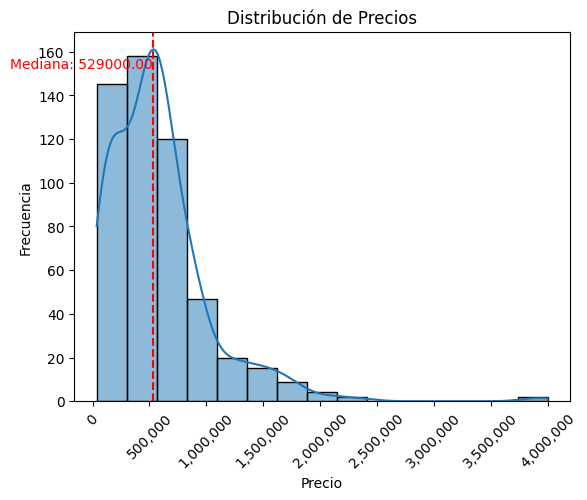

In [ ]:
plot_price_distribution(labels_df["price"])

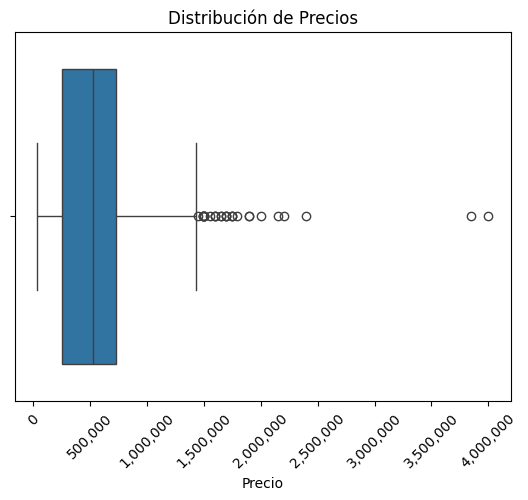

In [ ]:
plot_price_boxplot(labels_df["price"])

**Redondeando valores para disminuir variabilidad**

In [ ]:
labels_df["price"] = labels_df["price"].apply(custom_round)

**Tratamiento de outliers**

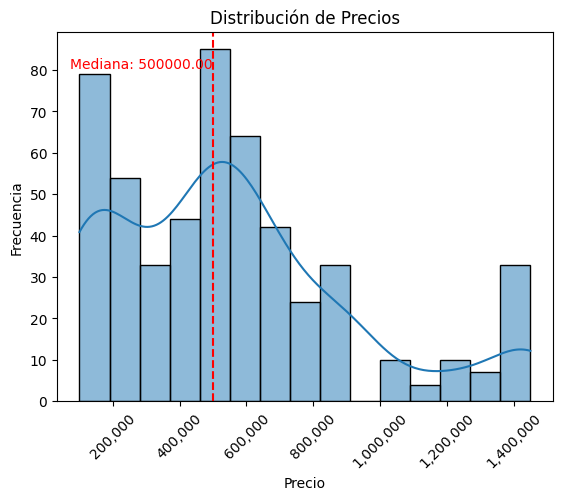

In [ ]:
df = handle_outliers_iqr(labels_df, "price")
plot_price_distribution(df["price"])

## Procesamiento de las imágenes

**Definiendo la cantidad de imágenes a aumentar por bin**

In [ ]:
intervals_df = count_by_bins(labels_df, 'price', bin_size=200_000)
intervals_df = intervals_df[intervals_df["Count"] != 0].reset_index(drop=True)
# intervals_df["multiplier"] = pd.Series([
#     4, 5, 3, 5, 3,
#     3, 4, 4, 4, 10,
#     30, 15, 15, 15,
# ])

intervals_df["multiplier"] = pd.Series([
    4, 6, 4, 7, 8,
    10, 10, 10, 3, 10,
    30, 15, 15, 15,
])

intervals_df["total_images"] = intervals_df["multiplier"] * intervals_df["Count"]
intervals_df.loc[:, ["total_images"]] = (
    intervals_df["Count"] + intervals_df["total_images"]
)
intervals_df["Final_percentage"] = round(
    intervals_df["total_images"] / intervals_df["total_images"].sum() * 100
)
print(
    f"Total de imágenes a usar en el entrenamiento: {intervals_df['total_images'].sum():,}"
)
intervals_df

Total de imágenes a usar en el entrenamiento: 3,458


,Interval,Count,Percentage,multiplier,total_images,Final_percentage
0,"(0 - 200,000]",133,25.0,4,665,19.0
1,"(200,000 - 400,000]",77,15.0,6,539,16.0
2,"(400,000 - 600,000]",149,29.0,4,745,22.0
3,"(600,000 - 800,000]",66,13.0,7,528,15.0
4,"(800,000 - 1,000,000]",43,8.0,8,387,11.0
5,"(1,000,000 - 1,200,000]",14,3.0,10,154,4.0
6,"(1,200,000 - 1,400,000]",12,2.0,10,132,4.0
7,"(1,400,000 - 1,600,000]",28,5.0,10,308,9.0


### Data Aumentation

In [ ]:
!rm -rf /content/Precio-Casas-CNN/images_processed
!mkdir /content/Precio-Casas-CNN/images_processed

# Se generan nuevas imagenes, usando la columna
# multiplier del dataframe anterior.

updated_df = generate_augmented_images(
    intervals_df,
    labels_df,
    input_dir=images_dir,
    output_dir=images_processed_dir,
)

Imagen 19426_bedroom.jpg guardada en /content/Precio-Casas-CNN/images_processed.


In [ ]:
# updated_df.drop_duplicates(subset="img", inplace=True)
print(f"Tamaño del DataFrame original: {labels_df.shape}")
print(f"Tamaño del DataFrame aumentado: {updated_df.shape}")

Tamaño del DataFrame original: (522, 7)
Tamaño del DataFrame aumentado: (3458, 7)


In [ ]:
# Pegando los archivos originales dentro de images_processed
!cp /content/Precio-Casas-CNN/train/* /content/Precio-Casas-CNN/images_processed

IMAGE_SIZE = (200, 200)
# Cómo se uniran las imagenes, por promedio o concatenación.
JOIN="mean"
images, prices = load_all_houses_images_and_prices(
    updated_df, images_processed_dir, size=IMAGE_SIZE, how=JOIN)

## Visualización de imágenes

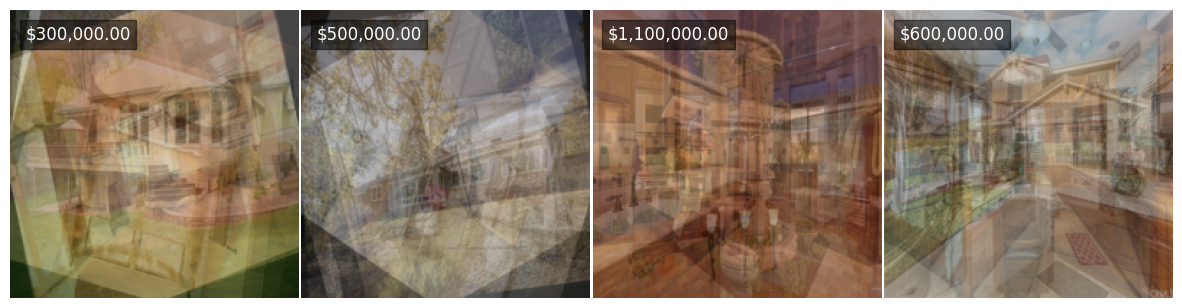

In [ ]:
show_images(images, prices=prices)

## Train, Validation & Test

In [ ]:
NUMBER_BINS = 5

# Paso 1: Discretizar la variable continua
bins = np.linspace(prices.min(), prices.max(), NUMBER_BINS)
labels = range(1, len(bins))  # Etiquetas para los bins
prices_binned = pd.cut(prices, bins=bins, labels=labels, include_lowest=True)

# Paso 2: Dividir el DataFrame en train y un conjunto temporal (test + validation)
X_train, temp_images, y_train, temp_prices = train_test_split(
    images, prices, test_size=0.3, random_state=42, stratify=prices_binned
)

# Paso 3: Discretizar nuevamente para el conjunto temporal
temp_prices_binned = pd.cut(temp_prices, bins=bins, labels=labels, include_lowest=True)

# Dividir el conjunto temporal en test y validation
X_val, X_test, y_val, y_test = train_test_split(
    temp_images,
    temp_prices,
    test_size=0.5,
    random_state=42,
    stratify=temp_prices_binned,
)

**Tamaño de los conjuntos de datos**

In [ ]:
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 2420
Tamaño del conjunto de validación: 519
Tamaño del conjunto de prueba: 519


#### Distribución de precios en Train

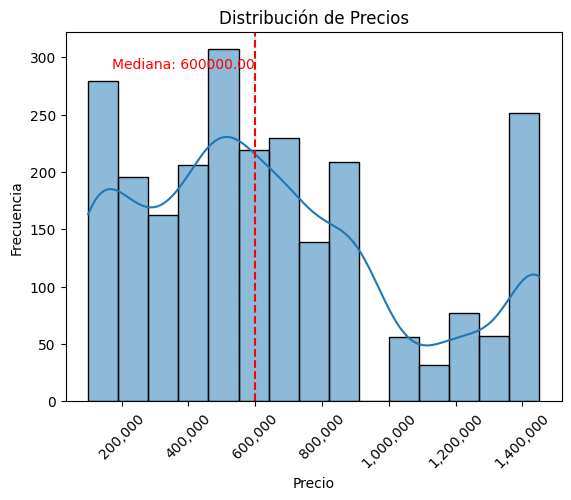

In [ ]:
plot_price_distribution(pd.Series(y_train))

#### Distribución de precio en Validation

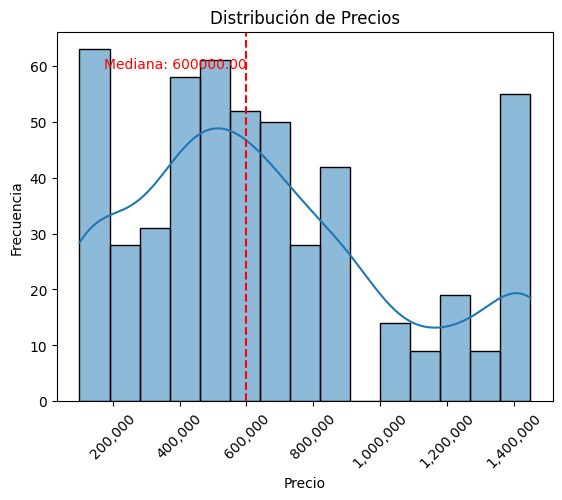

In [ ]:
plot_price_distribution(pd.Series(y_val))

**Escalamiento**

In [ ]:
scaler = RobustScaler()

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.reshape(-1, 1))

## Modelación

#### Generadores

In [ ]:
target_size = X_train[0].shape
batch_size = 32
class_mode = None

print(f"Tamaño de la imagen: {target_size}")

Tamaño de la imagen: (200, 200, 3)


In [ ]:
dgen_train = ImageDataGenerator()
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True)

dgen = ImageDataGenerator()

train_generator = dgen_train.flow(
    X_train,
    y_train_scaled,
    batch_size=batch_size,
)

validation_generator = dgen.flow(
    X_val,
    y_val_scaled,
    batch_size=batch_size,
)

test_generator = dgen.flow(
    X_test,
    y_test_scaled,
    batch_size=batch_size,
)

### Modelo Base

In [ ]:
!rm -rf models
!mkdir models

from keras.regularizers import l2
import tensorflow as tf

# # Primera capa de convolución
# model.add(Conv2D(neural_networks[0], kernel_size=(3, 3), padding="same", activation="relu", input_shape=target_size))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# # # Segunda capa de convolución
# model.add(Conv2D(neural_networks[1], kernel_size=(3, 3), padding="same", activation="relu", input_shape=target_size))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# # Tercera capa de convolución
# model.add(Conv2D(neural_networks[2], kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# # Cuarta capa de convolución (nueva)
# model.add(Conv2D(neural_networks[3], kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))
# # Aplanar los resultados de la convolución para la capa densa
# model.add(Flatten())
# model.add(Dense(neural_networks[4], activation="relu", kernel_regularizer=l2(0.01)))  # Regularización L2
# model.add(Dropout(0.5))
# model.add(Dense(neural_networks[5], activation="relu", kernel_regularizer=l2(0.01)))  # Regularización L2
# model.add(Dropout(0.5))

def build_model(neural_networks):

  model = Sequential()

  # Lista de capas de convolución
  conv_layers = [(neural_networks[key][0], neural_networks[key][1]) for key in neural_networks if key.startswith("conv")]

  # Añadir capas de convolución
  for i, (filters, dropout_rate) in enumerate(conv_layers):
      if i == 0:
          # Añadir la primera capa con input_shape
          model.add(Conv2D(neural_networks["input"][0], kernel_size=(3, 3), padding="same", activation="relu", input_shape=target_size))
      model.add(Conv2D(filters, kernel_size=(3, 3), padding="same", activation="relu"))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Dropout(dropout_rate))

  # Aplanar los resultados de la convolución
  model.add(Flatten())

  # Capas densas con regularización L2 y Dropout
  dense_layers = [(neural_networks[key][0], neural_networks[key][1]) for key in neural_networks if key.startswith("dense")]

  for units, dropout_rate in dense_layers:
      model.add(Dense(units, activation="relu", kernel_regularizer=l2(0.01)))
      model.add(Dropout(dropout_rate))

  # Capa de salida para regresión
  model.add(Dense(1, activation="linear", kernel_regularizer=l2(0.01)))

  return model


def generate_model_info_message(
    n_images, batch_size, metric, learning_rate, epochs, neural_networks,
    header=" "):
    # Generar información básica del modelo
    message = (
        f"{header}\n"
        f"*No. imágenes*: {n_images}\n"
        f"*Batch size*: {batch_size}\n"
        f"*Métrica*: {metric.replace('_', ' ')}\n"
        f"*Learning Rate*: {learning_rate}\n"
        f"*Épocas*: {epochs}\n"
        f"*Arquitectura de la Red Neuronal*:\n"
    )

    # Recorrer el diccionario para añadir cada capa al mensaje
    for layer, nodes in neural_networks.items():
        message += f"   ◦ {layer.capitalize()}: {nodes} {'filtros' if 'conv' in layer else 'nodos'}\n"

    return message


neural_networks = {
    "input": (16, 0.2),
    "conv1": (32, 0.3),
    "conv2": (64, 0.3),
    "conv3": (128, 0.4),
    "conv4": (256, 0.5),
    "dense1": (128, 0.5),
    "dense2": (64, 0.5)
}

metric = "val_mae"
learning_rate = 0.001
epochs = 50
chat_id="1475272549"

model = build_model(neural_networks)

telegram_notifier = TelegramNotifier(chat_id="1475272549")
model_info_message = generate_model_info_message(
    n_images=updated_df.shape[0],
    batch_size=batch_size,
    metric=metric,
    learning_rate=learning_rate,
    epochs=epochs,
    neural_networks=neural_networks,
    header="*Información del Modelo*\n",
)
telegram_notifier.send_telegram_message(model_info_message)


kmetrics = [
  RootMeanSquaredError(name="rms"),
  MeanAbsoluteError(name="mae"),
]

model.compile(
  optimizer=Adam(learning_rate=learning_rate),
  loss="huber_loss",
  metrics=kmetrics
)

custom_logger = CustomLogger(metric=metric, total_epochs=epochs, chat_id=chat_id)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "models/model_{val_mae:.4f}.keras",
    save_best_only=True,
    save_weights_only=False,
    monitor=metric,
    mode="min"
)

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint, custom_logger],
    verbose=0,
)



Últimas 10 épocas:
Epoch 40: {'loss': 0.2375, 'rms': 0.679, 'mae': 0.547, 'val_loss': 0.2336, 'val_rms': 0.6736, 'val_mae': 0.5398}
Epoch 41: {'loss': 0.2363, 'rms': 0.679, 'mae': 0.5472, 'val_loss': 0.2324, 'val_rms': 0.6734, 'val_mae': 0.5402}
Epoch 42: {'loss': 0.2352, 'rms': 0.6787, 'mae': 0.5477, 'val_loss': 0.2313, 'val_rms': 0.6733, 'val_mae': 0.5403}
Epoch 43: {'loss': 0.2342, 'rms': 0.679, 'mae': 0.5474, 'val_loss': 0.2304, 'val_rms': 0.6737, 'val_mae': 0.5397}
Epoch 44: {'loss': 0.2332, 'rms': 0.6789, 'mae': 0.5472, 'val_loss': 0.2294, 'val_rms': 0.6735, 'val_mae': 0.5401}
Epoch 45: {'loss': 0.2324, 'rms': 0.6791, 'mae': 0.5472, 'val_loss': 0.2286, 'val_rms': 0.6733, 'val_mae': 0.5403}
Epoch 46: {'loss': 0.2316, 'rms': 0.6786, 'mae': 0.5479, 'val_loss': 0.2278, 'val_rms': 0.6733, 'val_mae': 0.5403}
Epoch 47: {'loss': 0.2308, 'rms': 0.6786, 'mae': 0.5478, 'val_loss': 0.2271, 'val_rms': 0.6733, 'val_mae': 0.5403}
Epoch 48: {'loss': 0.2302, 'rms': 0.6789, 'mae': 0.5473, 'val_lo

<Axes: >

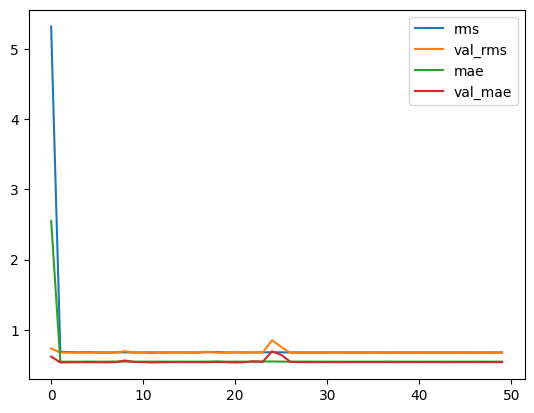

In [ ]:
results_df = pd.DataFrame(history.history)
results_df[["rms", "val_rms", "mae", "val_mae"]].plot()

## Evaluación de imágenes de Test

In [ ]:
scores = [float(model.split("_")[1].replace(".keras", "")) for model in os.listdir("./models/")]
best_score = round(min(scores), 4)
print("Mejor score", best_score)

Mejor score 0.5355


In [ ]:
# Test loss: 0.25
# Test RMS: 0.50
# Test MAE: 0.39

model = tf.keras.models.load_model(f"./models/model_{best_score:.4f}.keras")
test_loss, test_rms, test_mae = model.evaluate(test_generator)

print("Test loss: {:,.2f}\nTest RMS: {:,.2f}\nTest MAE: {:,.2f}".format(test_loss, test_rms, test_mae))

17/17 [==============================] - 3s 138ms/step - loss: 0.3087 - rms: 0.6892 - mae: 0.5451
Test loss: 0.31
Test RMS: 0.69
Test MAE: 0.55


### Precios predichos para Test

In [ ]:
results_df = evaluate_model(model, X_test, y_test_scaled, scaler=scaler)

total_error = results_df['Difference'].abs().sum().astype(int)
print(f"Error total {total_error:,}")

sorted_results = results_df.loc[results_df['Difference'].abs().sort_values(ascending=False).head(20).index]
sorted_results.style.format({
    "Price": "{:,.2f}",
    "Predicted_price": "{:,.2f}",
    "Difference": "{:,.2f}"
})

17/17 [==============================] - 2s 131ms/step
Error total 169,736,304


,Price,Predicted_price,Difference
179,"1,450,000.00","527,988.69","922,011.31"
424,"1,450,000.00","534,412.94","915,587.06"
175,"1,450,000.00","534,715.31","915,284.69"
432,"1,450,000.00","542,681.81","907,318.19"
513,"1,450,000.00","545,934.31","904,065.69"
174,"1,450,000.00","547,216.94","902,783.06"
327,"1,450,000.00","547,273.12","902,726.88"
200,"1,450,000.00","548,485.38","901,514.62"
462,"1,450,000.00","549,885.75","900,114.25"
63,"1,450,000.00","550,538.75","899,461.25"


## Para nuevas imagenes

In [ ]:
final_results_df = predict_from_folder(
    model,
    "/content/Precio-Casas-CNN/validate",
    target_size=IMAGE_SIZE,
    how=JOIN,
    scaler=scaler
)

1/1 [==============================] - 0s 38ms/step


In [ ]:
final_results_df["predicted_price"] = final_results_df["predicted_price"].round().astype(int)
final_results_df

,img,predicted_price
0,1583,536326
1,1603,547175
2,1608,565274
3,1707,547809
4,1742,541645
5,1771,560881
6,1848,558276
7,1859,507762
8,1904,556076
9,1989,514584


### Envíando resumen por Telegram

In [ ]:
summary_message = generate_model_info_message(
    n_images=int(updated_df.shape[0]),
    batch_size=batch_size,
    metric=metric,
    learning_rate=learning_rate,
    epochs=epochs,
    neural_networks=neural_networks,
    header="*Resumen del Modelo*\n",
)

summary_message += (
    "\n🎯 Métricas en Test\n"
        f"  ◦ Test loss: {test_loss:.2f}\n"
        f"  ◦ Test RMS: {test_rms:.2f}\n"
        f"  ◦ Test MAE: {test_mae:.2f}\n"
        f"  ◦ *Error total:* {total_error:,}\n"
    )

test_predictions_str = " | ".join(
    [f"{pred:,}" for pred in sorted_results["Predicted_price"].round().astype(int).head(10).to_list()]
)

results_str = "\n".join(
    [f"{img}  {pred}" for img, pred in zip(final_results_df["img"].head(10), final_results_df["predicted_price"].head(10))]
)


summary_message += (
    "\n"
    f"• *Precios de test:*\n{test_predictions_str}\n\n"
    f"• *Precios predichos:*\n{results_str}"
)

telegram_notifier.send_telegram_message(summary_message)

print(summary_message)

*Resumen del Modelo*

*No. imágenes*: 3458
*Batch size*: 32
*Métrica*: val mae
*Learning Rate*: 0.001
*Épocas*: 50
*Arquitectura de la Red Neuronal*:
   ◦ Input: (16, 0.2) nodos
   ◦ Conv1: (32, 0.3) filtros
   ◦ Conv2: (64, 0.3) filtros
   ◦ Conv3: (128, 0.4) filtros
   ◦ Conv4: (256, 0.5) filtros
   ◦ Dense1: (128, 0.5) nodos
   ◦ Dense2: (64, 0.5) nodos

🎯 Métricas en Test
  ◦ Test loss: 0.31
  ◦ Test RMS: 0.69
  ◦ Test MAE: 0.55
  ◦ *Error total:* 169,736,304

• *Precios de test:*
527,989 | 534,413 | 534,715 | 542,682 | 545,934 | 547,217 | 547,273 | 548,485 | 549,886 | 550,539

• *Precios predichos:*
1583  536326
1603  547175
1608  565274
1707  547809
1742  541645
1771  560881
1848  558276
1859  507762
1904  556076
1989  514584
